## 1. Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


In [14]:
df_sample.shape

(150000, 59)

In [17]:
# Load raw data
raw_data_dir = Path('data/raw')
activity_files = list(raw_data_dir.glob('uniprot_*/*_chembl_activities.parquet'))

print(f"Found {len(activity_files)} UniProt activity files")
print(f"Loading first 50 files for analysis...")

# Load subset for faster analysis
sample_activities = []
for file in activity_files[:]:
    try:
        df = pd.read_parquet(file)
        sample_activities.append(df)
    except Exception as e:
        print(f"Error loading {file}: {e}")

df_sample = pd.concat(sample_activities, ignore_index=True)
print(f"\nLoaded {len(df_sample):,} activities from {len(sample_activities)} files")
print(f"DataFrame shape: {df_sample.shape}")

Found 361 UniProt activity files
Loading first 50 files for analysis...

Loaded 1,083,000 activities from 361 files
DataFrame shape: (1083000, 58)

Loaded 1,083,000 activities from 361 files
DataFrame shape: (1083000, 58)


## 2. Check Assay Condition Column Availability

In [18]:
# Define assay condition columns from overlapping paper
assay_condition_cols = [
    'assay_type',
    'assay_organism',
    'assay_category',
    'assay_tax_id',
    'assay_strain',
    'assay_tissue',
    'assay_cell_type',
    'assay_subcellular_fraction',
    'bao_format',
    'variant_id'
]

print("="*80)
print("ASSAY CONDITION COLUMN ANALYSIS")
print("="*80)

# Check which columns exist
existing_cols = [col for col in assay_condition_cols if col in df_sample.columns]
missing_cols = [col for col in assay_condition_cols if col not in df_sample.columns]

print(f"\nExisting columns: {len(existing_cols)}/{len(assay_condition_cols)}")
for col in existing_cols:
    print(f"  ✓ {col}")

if missing_cols:
    print(f"\nMissing columns: {len(missing_cols)}")
    for col in missing_cols:
        print(f"  ✗ {col}")

ASSAY CONDITION COLUMN ANALYSIS

Existing columns: 9/10
  ✓ assay_type
  ✓ assay_organism
  ✓ assay_category
  ✓ assay_tax_id
  ✓ assay_strain
  ✓ assay_tissue
  ✓ assay_cell_type
  ✓ assay_subcellular_fraction
  ✓ bao_format

Missing columns: 1
  ✗ variant_id


## 3. Analyze Null Percentage for Each Column

In [19]:
# Calculate null percentages
null_analysis = pd.DataFrame({
    'Column': existing_cols,
    'Non-Null Count': [df_sample[col].notna().sum() for col in existing_cols],
    'Null Count': [df_sample[col].isna().sum() for col in existing_cols],
    'Total': len(df_sample)
})

null_analysis['Non-Null %'] = (null_analysis['Non-Null Count'] / null_analysis['Total'] * 100).round(2)
null_analysis['Null %'] = (null_analysis['Null Count'] / null_analysis['Total'] * 100).round(2)

# Sort by null percentage
null_analysis = null_analysis.sort_values('Null %', ascending=False)

print("\nNull Value Analysis:")
print("="*80)
display(null_analysis[['Column', 'Non-Null Count', 'Null Count', 'Non-Null %', 'Null %']])


Null Value Analysis:


,Column,Non-Null Count,Null Count,Non-Null %,Null %
1,assay_organism,0,1083000,0.0,100.0
2,assay_category,0,1083000,0.0,100.0
3,assay_tax_id,0,1083000,0.0,100.0
4,assay_strain,0,1083000,0.0,100.0
5,assay_tissue,0,1083000,0.0,100.0
6,assay_cell_type,0,1083000,0.0,100.0
7,assay_subcellular_fraction,0,1083000,0.0,100.0
0,assay_type,1083000,0,100.0,0.0
8,bao_format,1083000,0,100.0,0.0


In [28]:
for col in df.columns:
    print(f"{col}", df[col].notna().sum()/df.shape[0])

molecule_chembl_id 1.0
compound_key 0.0
canonical_smiles 0.9933333333333333
molecule_pref_name 0.07666666666666666
standard_type 1.0
standard_value 0.969
standard_units 1.0
standard_relation 0.9686666666666667
standard_text_value 0.0
pchembl_value 0.7716666666666666
activity_comment 0.030666666666666665
data_validity_comment 0.06533333333333333
assay_chembl_id 1.0
assay_description 1.0
assay_type 1.0
assay_organism 0.0
assay_category 0.0
assay_tax_id 0.0
assay_strain 0.0
assay_tissue 0.0
assay_cell_type 0.0
assay_subcellular_fraction 0.0
assay_tissue_chembl_id 0.0
assay_cell_chembl_id 0.0
assay_parameters 0.0
assay_variant_accession 0.0
assay_variant_mutation 0.0
bao_label 1.0
bao_format 1.0
bao_format_id 0.0
target_chembl_id 1.0
target_pref_name 1.0
target_organism 1.0
target_type 0.0
document_chembl_id 1.0
document_journal 1.0
document_year 1.0
doc_type 0.0
source_description 0.0
src_id 1.0
uo_units 1.0
ligand_efficiency_bei 0.0
ligand_efficiency_le 0.0
ligand_efficiency_lle 0.0
liga

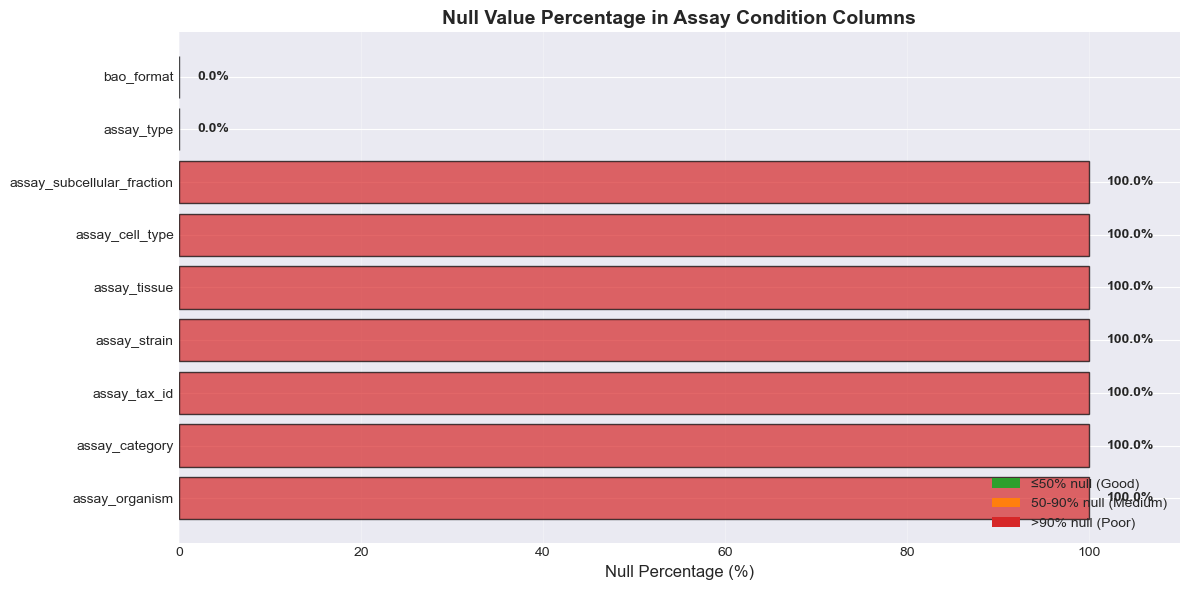

In [21]:
# Visualize null percentages
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['#d62728' if x > 90 else '#ff7f0e' if x > 50 else '#2ca02c' 
          for x in null_analysis['Null %']]

bars = ax.barh(null_analysis['Column'], null_analysis['Null %'], color=colors, alpha=0.7, edgecolor='black')

# Add percentage labels
for i, (bar, val) in enumerate(zip(bars, null_analysis['Null %'])):
    width = bar.get_width()
    ax.text(width + 2, bar.get_y() + bar.get_height()/2,
            f'{val:.1f}%',
            ha='left', va='center', fontsize=10, fontweight='bold')

ax.set_xlabel('Null Percentage (%)', fontsize=12)
ax.set_title('Null Value Percentage in Assay Condition Columns', fontsize=14, fontweight='bold')
ax.set_xlim(0, 110)
ax.grid(axis='x', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ca02c', label='≤50% null (Good)'),
    Patch(facecolor='#ff7f0e', label='50-90% null (Medium)'),
    Patch(facecolor='#d62728', label='>90% null (Poor)')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

## 4. Analyze Unique Values in Non-Null Columns

In [22]:
# For columns with <50% null, check unique values
low_null_cols = null_analysis[null_analysis['Null %'] < 50]['Column'].tolist()

if low_null_cols:
    print("\nUnique Value Analysis (for columns with <50% null):")
    print("="*80)
    
    for col in low_null_cols:
        non_null_data = df_sample[col].dropna()
        unique_count = non_null_data.nunique()
        
        print(f"\n{col}:")
        print(f"  Unique values: {unique_count}")
        print(f"  Top 10 values:")
        
        value_counts = non_null_data.value_counts().head(10)
        for val, count in value_counts.items():
            pct = count / len(non_null_data) * 100
            print(f"    {val}: {count:,} ({pct:.1f}%)")
else:
    print("\nNo columns with <50% null values found.")


Unique Value Analysis (for columns with <50% null):

assay_type:
  Unique values: 3
  Top 10 values:
    B: 798,532 (73.7%)
    F: 281,580 (26.0%)
    A: 2,888 (0.3%)

bao_format:
  Unique values: 9
  Top 10 values:
    BAO_0000357: 470,383 (43.4%)
    BAO_0000219: 361,361 (33.4%)
    BAO_0000019: 104,690 (9.7%)
    BAO_0000218: 47,291 (4.4%)
    BAO_0000223: 45,486 (4.2%)
    BAO_0000224: 27,797 (2.6%)
    BAO_0000221: 15,162 (1.4%)
    BAO_0000366: 5,776 (0.5%)
    BAO_0000249: 5,054 (0.5%)


## 5. Test Hash Generation Impact

In [23]:
# Generate hash using existing columns only
import hashlib

def create_assay_hash(row, cols):
    condition_str = '|'.join([str(row[col]) if pd.notna(row[col]) else '' for col in cols])
    return hashlib.md5(condition_str.encode()).hexdigest()

if existing_cols:
    print("Testing hash generation...")
    df_sample['assay_conditions_hash'] = df_sample.apply(
        lambda row: create_assay_hash(row, existing_cols), axis=1
    )
    
    unique_hashes = df_sample['assay_conditions_hash'].nunique()
    print(f"\nGenerated {unique_hashes:,} unique assay condition hashes")
    print(f"From {len(df_sample):,} total activities")
    print(f"Hash compression ratio: {len(df_sample) / unique_hashes:.1f}x")
    
    # Check if many null values lead to same hash
    print("\nMost common hashes (top 10):")
    hash_counts = df_sample['assay_conditions_hash'].value_counts().head(10)
    for i, (hash_val, count) in enumerate(hash_counts.items(), 1):
        pct = count / len(df_sample) * 100
        print(f"{i}. Hash {hash_val[:16]}...: {count:,} activities ({pct:.1f}%)")
        
        # Show what values produce this hash
        sample_row = df_sample[df_sample['assay_conditions_hash'] == hash_val].iloc[0]
        print(f"   Values: {', '.join([f'{col}={sample_row[col]}' for col in existing_cols[:5]])}")

Testing hash generation...

Generated 14 unique assay condition hashes
From 1,083,000 total activities
Hash compression ratio: 77357.1x

Most common hashes (top 10):
1. Hash d35e17272e54b273...: 467,495 activities (43.2%)
   Values: assay_type=B, assay_organism=None, assay_category=None, assay_tax_id=None, assay_strain=None
2. Hash 8fc1cbd654475fdc...: 198,911 activities (18.4%)

Generated 14 unique assay condition hashes
From 1,083,000 total activities
Hash compression ratio: 77357.1x

Most common hashes (top 10):
1. Hash d35e17272e54b273...: 467,495 activities (43.2%)
   Values: assay_type=B, assay_organism=None, assay_category=None, assay_tax_id=None, assay_strain=None
2. Hash 8fc1cbd654475fdc...: 198,911 activities (18.4%)
   Values: assay_type=B, assay_organism=None, assay_category=None, assay_tax_id=None, assay_strain=None
3. Hash 4118d2dcef045215...: 162,450 activities (15.0%)
   Values: assay_type=F, assay_organism=None, assay_category=None, assay_tax_id=None, assay_strain=None

## 6. Compare Hash vs Assay ID

Comparing grouping methods:

Unique assay_chembl_id: 631
Unique assay_conditions_hash: 14

Ratio (assays per hash): 45.07

Assays per hash distribution:
  Mean: 45.07
  Median: 15
  Max: 253
  Min: 1


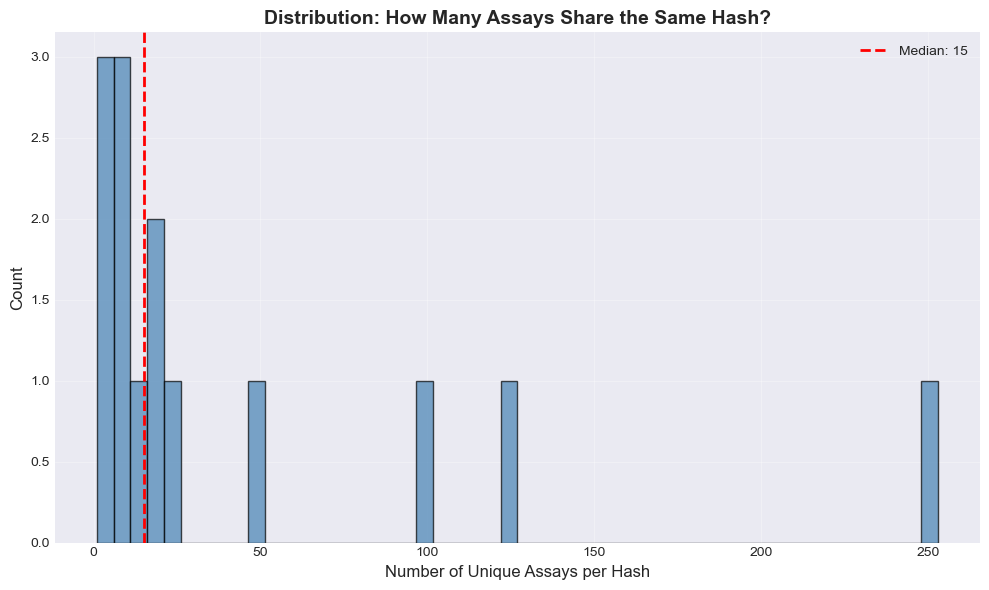

In [24]:
# Compare hash-based grouping vs assay_chembl_id grouping
print("Comparing grouping methods:")
print("="*80)

if 'assay_chembl_id' in df_sample.columns:
    unique_assays = df_sample['assay_chembl_id'].nunique()
    print(f"\nUnique assay_chembl_id: {unique_assays:,}")
    print(f"Unique assay_conditions_hash: {unique_hashes:,}")
    print(f"\nRatio (assays per hash): {unique_assays / unique_hashes:.2f}")
    
    # Check how many assays map to same hash
    assay_hash_map = df_sample.groupby('assay_conditions_hash')['assay_chembl_id'].nunique()
    print(f"\nAssays per hash distribution:")
    print(f"  Mean: {assay_hash_map.mean():.2f}")
    print(f"  Median: {assay_hash_map.median():.0f}")
    print(f"  Max: {assay_hash_map.max():.0f}")
    print(f"  Min: {assay_hash_map.min():.0f}")
    
    # Show distribution
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(assay_hash_map.values, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    ax.set_xlabel('Number of Unique Assays per Hash', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('Distribution: How Many Assays Share the Same Hash?', fontsize=14, fontweight='bold')
    ax.axvline(assay_hash_map.median(), color='red', linestyle='--', linewidth=2, 
               label=f'Median: {assay_hash_map.median():.0f}')
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

## 7. Check Duplicate Patterns

In [25]:
# Check for exact duplicates (molecule + assay + value)
if all(col in df_sample.columns for col in ['molecule_chembl_id', 'assay_chembl_id', 'pchembl_value']):
    print("Analyzing duplicate patterns:")
    print("="*80)
    
    # Convert pchembl_value to numeric
    df_sample['pchembl_value'] = pd.to_numeric(df_sample['pchembl_value'], errors='coerce')
    
    total = len(df_sample)
    
    # Check exact duplicates
    exact_dupes = df_sample.duplicated(
        subset=['molecule_chembl_id', 'assay_chembl_id', 'pchembl_value'],
        keep=False
    ).sum()
    
    print(f"\nExact duplicates (molecule + assay + value): {exact_dupes:,} ({exact_dupes/total*100:.1f}%)")
    
    # Check molecule-assay pairs with multiple values
    mol_assay_counts = df_sample.groupby(['molecule_chembl_id', 'assay_chembl_id']).size()
    replicates = (mol_assay_counts > 1).sum()
    replicate_activities = mol_assay_counts[mol_assay_counts > 1].sum()
    
    print(f"\nMolecule-assay pairs with multiple values (replicates):")
    print(f"  Pairs: {replicates:,}")
    print(f"  Total activities: {replicate_activities:,} ({replicate_activities/total*100:.1f}%)")
    
    # Show example replicates
    print("\nExample replicate (same molecule + assay, different values):")
    replicate_pairs = mol_assay_counts[mol_assay_counts > 1].head(1)
    if len(replicate_pairs) > 0:
        mol_id, assay_id = replicate_pairs.index[0]
        examples = df_sample[
            (df_sample['molecule_chembl_id'] == mol_id) & 
            (df_sample['assay_chembl_id'] == assay_id)
        ][['molecule_chembl_id', 'assay_chembl_id', 'pchembl_value', 'standard_type']]
        display(examples)

Analyzing duplicate patterns:

Exact duplicates (molecule + assay + value): 1,083,000 (100.0%)

Molecule-assay pairs with multiple values (replicates):
  Pairs: 2,976
  Total activities: 1,083,000 (100.0%)

Example replicate (same molecule + assay, different values):

Molecule-assay pairs with multiple values (replicates):
  Pairs: 2,976
  Total activities: 1,083,000 (100.0%)

Example replicate (same molecule + assay, different values):


,molecule_chembl_id,assay_chembl_id,pchembl_value,standard_type
2718,CHEMBL10,CHEMBL732625,6.54,IC50
5718,CHEMBL10,CHEMBL732625,6.54,IC50
8718,CHEMBL10,CHEMBL732625,6.54,IC50
11718,CHEMBL10,CHEMBL732625,6.54,IC50
14718,CHEMBL10,CHEMBL732625,6.54,IC50
...,...,...,...,...
1070718,CHEMBL10,CHEMBL732625,6.54,IC50
1073718,CHEMBL10,CHEMBL732625,6.54,IC50
1076718,CHEMBL10,CHEMBL732625,6.54,IC50
1079718,CHEMBL10,CHEMBL732625,6.54,IC50


## 8. Summary and Recommendations

In [26]:
print("="*80)
print("SUMMARY AND RECOMMENDATIONS")
print("="*80)

print("\n1. DATA AVAILABILITY:")
print(f"   • Found {len(existing_cols)}/{len(assay_condition_cols)} assay condition columns")
high_null = null_analysis[null_analysis['Null %'] > 90]
if len(high_null) > 0:
    print(f"   • {len(high_null)} columns have >90% null values:")
    for col in high_null['Column']:
        print(f"     - {col}")

print("\n2. HASH EFFECTIVENESS:")
if 'assay_conditions_hash' in df_sample.columns:
    print(f"   • {unique_hashes:,} unique hashes from {len(df_sample):,} activities")
    print(f"   • Compression ratio: {len(df_sample) / unique_hashes:.1f}x")
    print(f"   • This means hash groups {len(df_sample) / unique_hashes:.1f} activities on average")

print("\n3. DUPLICATE ANALYSIS:")
if 'exact_dupes' in locals():
    print(f"   • Exact duplicates: {exact_dupes:,} ({exact_dupes/total*100:.1f}%)")
    print(f"   • Replicates: {replicate_activities:,} ({replicate_activities/total*100:.1f}%)")
    print(f"   • Combined removal potential: {(exact_dupes + replicate_activities - replicates)/total*100:.1f}%")

print("\n4. RECOMMENDATIONS:")
print("   • Consider using assay_chembl_id instead of hash if columns are mostly null")
print("   • Review which assay condition columns are actually informative")
print("   • Investigate if 99.7% removal rate is expected for your use case")
print("   • May need to adjust deduplication strategy based on data quality")

SUMMARY AND RECOMMENDATIONS

1. DATA AVAILABILITY:
   • Found 9/10 assay condition columns
   • 7 columns have >90% null values:
     - assay_organism
     - assay_category
     - assay_tax_id
     - assay_strain
     - assay_tissue
     - assay_cell_type
     - assay_subcellular_fraction

2. HASH EFFECTIVENESS:
   • 14 unique hashes from 1,083,000 activities
   • Compression ratio: 77357.1x
   • This means hash groups 77357.1 activities on average

3. DUPLICATE ANALYSIS:
   • Exact duplicates: 1,083,000 (100.0%)
   • Replicates: 1,083,000 (100.0%)
   • Combined removal potential: 199.7%

4. RECOMMENDATIONS:
   • Consider using assay_chembl_id instead of hash if columns are mostly null
   • Review which assay condition columns are actually informative
   • Investigate if 99.7% removal rate is expected for your use case
   • May need to adjust deduplication strategy based on data quality


In [32]:
import pandas as pd
assay_df = pd.read_csv("data/chembl_API_test/assays.csv")
assay_df

,Unnamed: 0,aidx,assay_category,assay_cell_type,assay_chembl_id,assay_classifications,assay_group,assay_organism,assay_parameters,assay_strain,...,confidence_score,description,document_chembl_id,relationship_description,relationship_type,src_assay_id,src_id,target_chembl_id,tissue_chembl_id,variant_sequence
0,0,CLD0,NaN,CCRF-CEM,CHEMBL651396,[],NaN,Homo sapiens,[],NaN,...,1,Effective concentration of compound achieving ...,CHEMBL1138695,Non-molecular target assigned,N,NaN,1,CHEMBL382,NaN,NaN
1,1,CLD0,NaN,NaN,CHEMBL657848,[],NaN,NaN,[],NaN,...,8,Inhibitory activity against human carbonic anh...,CHEMBL1146805,Homologous protein target assigned,H,NaN,1,CHEMBL205,NaN,NaN
2,2,CLD0,NaN,NaN,CHEMBL657970,[],NaN,NaN,[],NaN,...,8,Inhibitory activity against human carbonic anh...,CHEMBL1146805,Homologous protein target assigned,H,NaN,1,CHEMBL3594,NaN,NaN
3,3,CLD0,NaN,NaN,CHEMBL873200,[],NaN,NaN,[],NaN,...,8,Inhibitory activity against human carbonic anh...,CHEMBL1146805,Homologous protein target assigned,H,NaN,1,CHEMBL261,NaN,NaN
4,4,CLD0,NaN,NaN,CHEMBL666153,[],NaN,Cavia porcellus,[],NaN,...,8,Inhibition of cytochrome P450 1A2 of isolated ...,CHEMBL1148425,Homologous protein target assigned,H,NaN,1,CHEMBL3356,NaN,NaN
5,5,CLD0,NaN,NaN,CHEMBL660388,[],NaN,Cavia porcellus,[],NaN,...,8,Inhibition of cytochrome P450 2C9 of isolated ...,CHEMBL1148425,Homologous protein target assigned,H,NaN,1,CHEMBL3397,NaN,NaN
6,6,CLD0,NaN,NaN,CHEMBL665756,[],NaN,Cavia porcellus,[],NaN,...,8,Inhibition of cytochrome P450 3A4 of isolated ...,CHEMBL1148425,Homologous protein target assigned,H,NaN,1,CHEMBL340,NaN,NaN
7,7,CLD0,NaN,NaN,CHEMBL663853,[],NaN,NaN,[],NaN,...,8,Inhibitory concentration against human DNA top...,CHEMBL1137930,Homologous protein target assigned,H,NaN,1,CHEMBL1806,NaN,NaN
8,8,CLD0,NaN,NaN,CHEMBL872937,[],NaN,NaN,[],NaN,...,8,In vivo inhibitory activity against human Hepa...,CHEMBL1146658,Homologous protein target assigned,H,NaN,1,CHEMBL3921,NaN,NaN
